## Llibreries

In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix


## EDA (Exploratory Data Analysis)

Primer llegim el csv de les dades i les guardem. En aquest cas, totes les dades es troben només en un únic csv.

In [128]:
dataset = pd.read_csv('data/Pokemon.csv')

In [129]:
dataset.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

Com podem veure, la primera columna no ens aporta gens d'informació rellevant per fer la classificació.

In [130]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Es pot observar que quasi bé tots els atributs son del tipus int64. També cal veure que del type2, només hi han 414 valors, per  tant hi han 386 valors perduts.

In [131]:
dataset.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Podem veure que només el atribut Type 2 té valors nulls. Però aquest atribut no el tindrem en compte alhora de fer la nostra classificació de llegendari. Primer eliminem les columnes no necessàries que son: #, name, type 1 i type2, i fem l'estudi sobre les altres. 

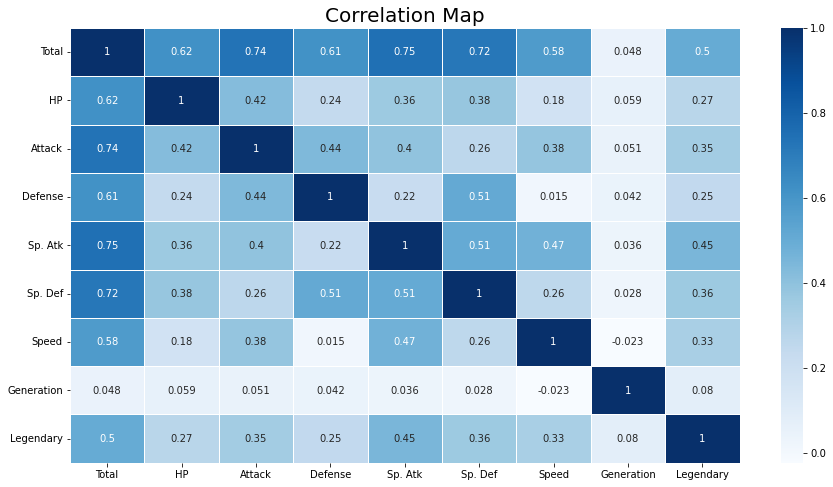

In [132]:
plt.rcParams['figure.figsize']=(15,8)
heat_map = sns.heatmap(dataset[['Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']].corr(), annot = True, linewidths=1, cmap='Blues')
heat_map.set_title(label='Correlation Map', fontsize=20)
heat_map;

In [133]:
dataset.drop('#', axis=1, inplace=True)
dataset.drop('Name', axis=1, inplace=True)
dataset.drop('Type 1', axis=1, inplace=True)
dataset.drop('Type 2', axis=1, inplace=True)

In [134]:
dataset['Legendary'] = dataset['Legendary'].astype(int)

Transformem el boleà de Lengendary a 0 i 1.

In [135]:
dataset.head()

Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary
0    318  45      49       49       65       65     45           1          0
1    405  60      62       63       80       80     60           1          0
2    525  80      82       83      100      100     80           1          0
3    625  80     100      123      122      120     80           1          0
4    309  39      52       43       60       50     65           1          0

Eliminem del dataset les columnes que no volem per fer l'estudi de si un Pokemon és o no llegendari.

Mostrem la quantitat de mostres en el dataset que tenen valor 1 a Legendary

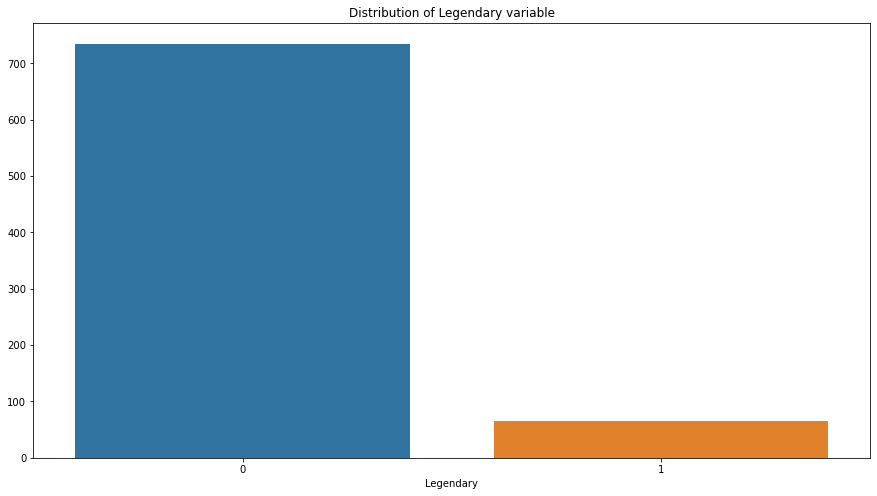

In [136]:
sns.barplot(data=dataset['Legendary'].value_counts().reset_index(), x='index', y='Legendary')
plt.xlabel('Legendary')
plt.ylabel('')
plt.title('Distribution of Legendary variable')
plt.show()

## Model selection

Primer de tot separem les nostres dades en train i test. Utilitzaré la distribució de 80% train i 20% test

In [137]:
X = dataset[['Total','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']]
Y = dataset['Legendary']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Utilitzaré el GridSearch per tal de trobar els millors hiperparàmetres de cada model. Els models utilitzats seran: SVM, Decicion Tree, KNN i Logistic Regression

In [138]:
param_svm = {'kernel': ['rbf', 'poly', 'sigmoid']}
param_knn = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
param_decisiontree = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"] }

param_logireg = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

param_grid = [param_svm, param_knn, param_decisiontree, param_logireg]

models = [svm.SVC(probability=True), KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression()]
nom_models = ["Support Vector Machines", "KNN", "Decision Tree", "Logistic Regression"]

for i,model in enumerate(models):
    '''Busqueda exhaustiva de los mejores parametros'''
    print("BÚSQUEDA EXHAUSTIVA DE PARAMETRES")
    grid = GridSearchCV(model, param_grid[i], verbose=3, n_jobs=-1)
    grid.fit(X,Y)
    print("Els millors parametres: ",model,grid.best_params_)
    print("El millor score: ", grid.best_score_)
    print("")

BÚSQUEDA EXHAUSTIVA DE PARAMETRES
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Els millors parametres:  SVC(probability=True) {'kernel': 'poly'}
El millor score:  0.9375

BÚSQUEDA EXHAUSTIVA DE PARAMETRES
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Els millors parametres:  KNeighborsClassifier() {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'}
El millor score:  0.96

BÚSQUEDA EXHAUSTIVA DE PARAMETRES
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Els millors parametres:  DecisionTreeClassifier() {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}
El millor score:  0.95

BÚSQUEDA EXHAUSTIVA DE PARAMETRES
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Els millors parametres:  LogisticRegression() {'C': 0.1}
El millor score:  0.94375



## Confusion matrix i ROC Curves

## SVM

C:\Users\annaa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


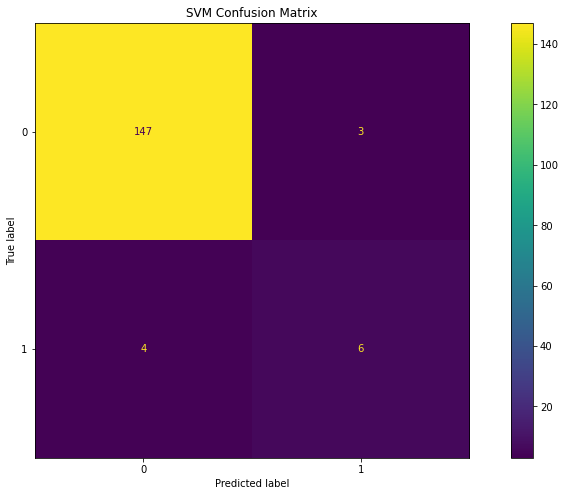

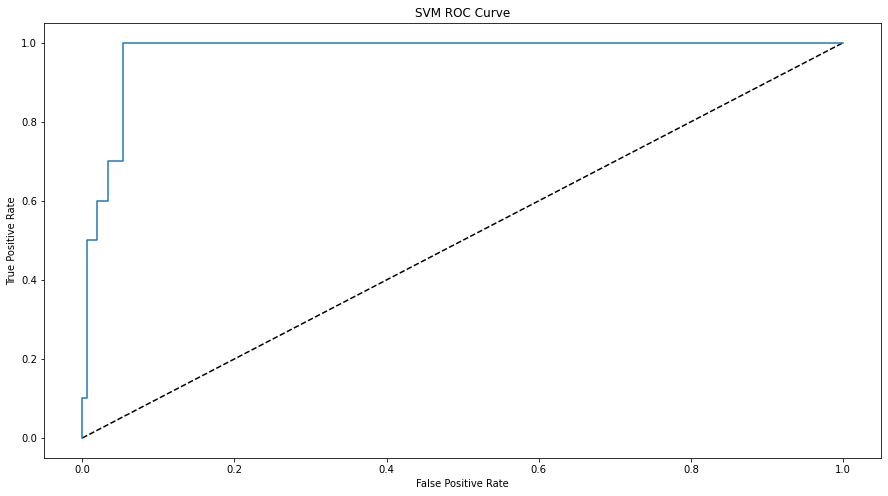

In [176]:
plot_confusion_matrix(model_svm, x_test, y_test)
plt.title('SVM Confusion Matrix')
plt.show()

model = svm.SVC(probability=True,kernel='poly')
model.fit(x_train, y_train)
predicted_svm_hp = model.predict(x_test)

y_pred_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.show()

## KNN

C:\Users\annaa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


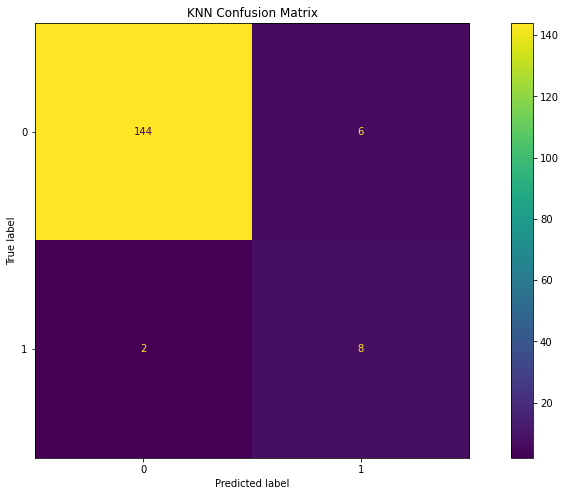

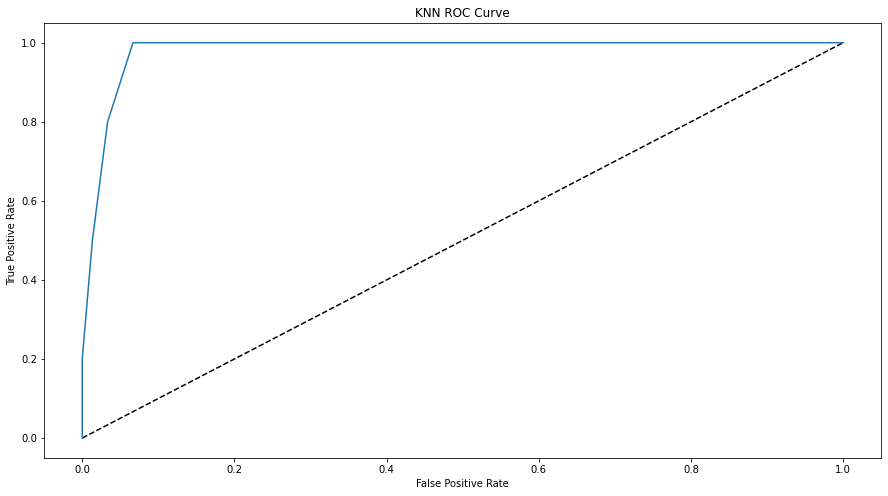

In [177]:
plot_confusion_matrix(model_knn, x_test, y_test)
plt.title('KNN Confusion Matrix')
plt.show()

model =  KNeighborsClassifier(metric='minkowski', n_neighbors=7, weights='uniform')
model.fit(x_train, y_train)
predicted_knn_hp = model.predict(x_test)

y_pred_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.show()

## Decision Tree

C:\Users\annaa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


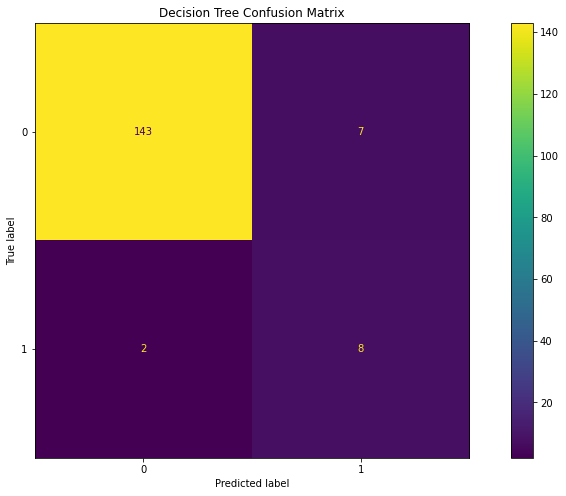

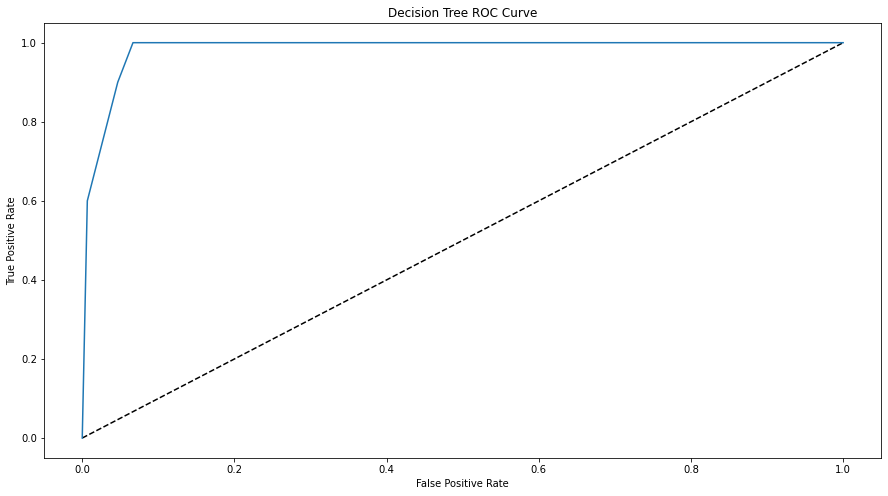

In [178]:
plot_confusion_matrix(model_tree, x_test, y_test)
plt.title('Decision Tree Confusion Matrix')
plt.show()

model = DecisionTreeClassifier(criterion='gini',max_depth=3,min_samples_leaf=20)
model.fit(x_train, y_train)
predicted_tree_hp = model.predict(x_test)

y_pred_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

## Logistic Regression

C:\Users\annaa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


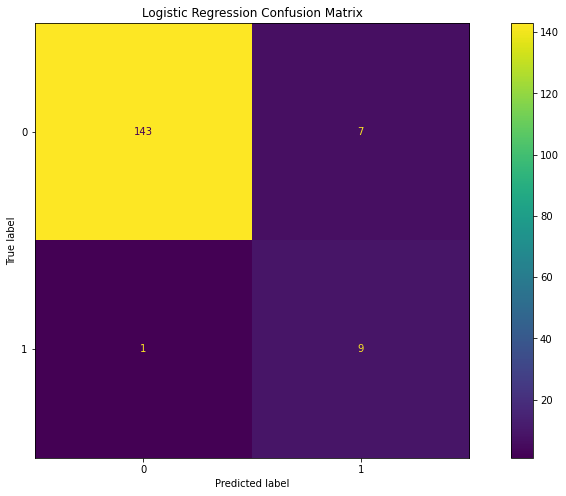

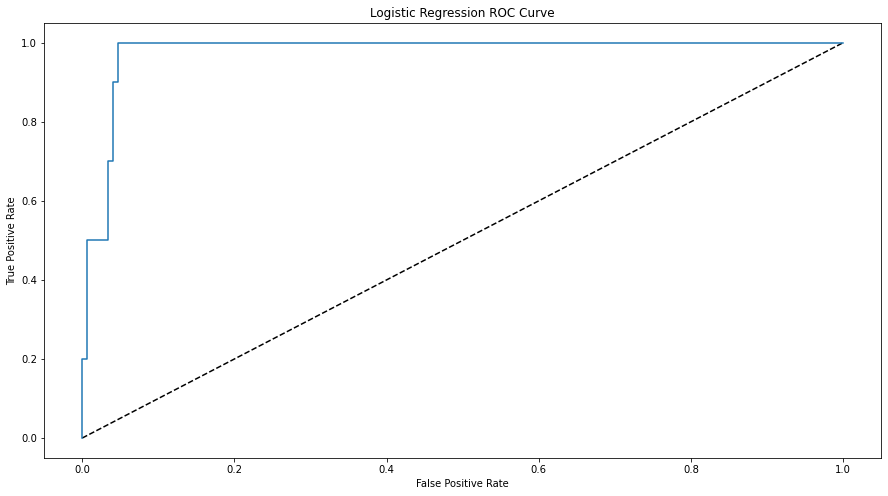

In [179]:
plot_confusion_matrix(model, x_test, y_test)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

model = LogisticRegression(max_iter=150,C=0.1)
model.fit(x_train, y_train)
predicted_log_hp = model.predict(x_test)

y_pred_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [186]:
print("Accuracy : ", accuracy_score(y_test, predicted_svm))
print("Accuracy  amb Hiperparametres : ", accuracy_score(y_test, predicted_svm_hp))

Accuracy :  0.95625
Accuracy  amb Hiperparametres :  0.95


In [187]:
print("Accuracy : ", accuracy_score(y_test, predicted_knn))
print("Accuracy amb Hiperparametres: ", accuracy_score(y_test, predicted_knn_hp))

Accuracy :  0.95
Accuracy amb Hiperparametres:  0.95625


In [188]:
print("Accuracy : ", accuracy_score(y_test, predicted_tree))
print("Accuracy amb Hiperparametres: ", accuracy_score(y_test, predicted_tree_hp))

Accuracy :  0.94375
Accuracy amb Hiperparametres:  0.95


In [189]:
print("Accuracy : ", accuracy_score(y_test, predicted_log))
print("Accuracy amb Hiperparametres: ", accuracy_score(y_test, predicted_log_hp))

Accuracy :  0.94375
Accuracy amb Hiperparametres:  0.94375


# Conclusions

S'ha de tenir en compte que a les dades utilitzades per entrenar els models, hi havien molts poc casos en el que Legendary tingués el valor 1, True. Igualment, l'accuracy general dels models ha estat bastant bona.
Amb aquests resultats podem observar el que millor accuracy obté és el SVM original i el KNN amb els millors hiperparametres que son: metric='minkowski', n_neighbors=7, weights='uniform'.
